In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import re

plt.rcParams['figure.figsize'] = 21, 15
plt.rcParams['xtick.labelsize']=65
plt.rcParams['ytick.labelsize']=65
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'figure.autolayout': False})
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['font.family'] = 'Arial'

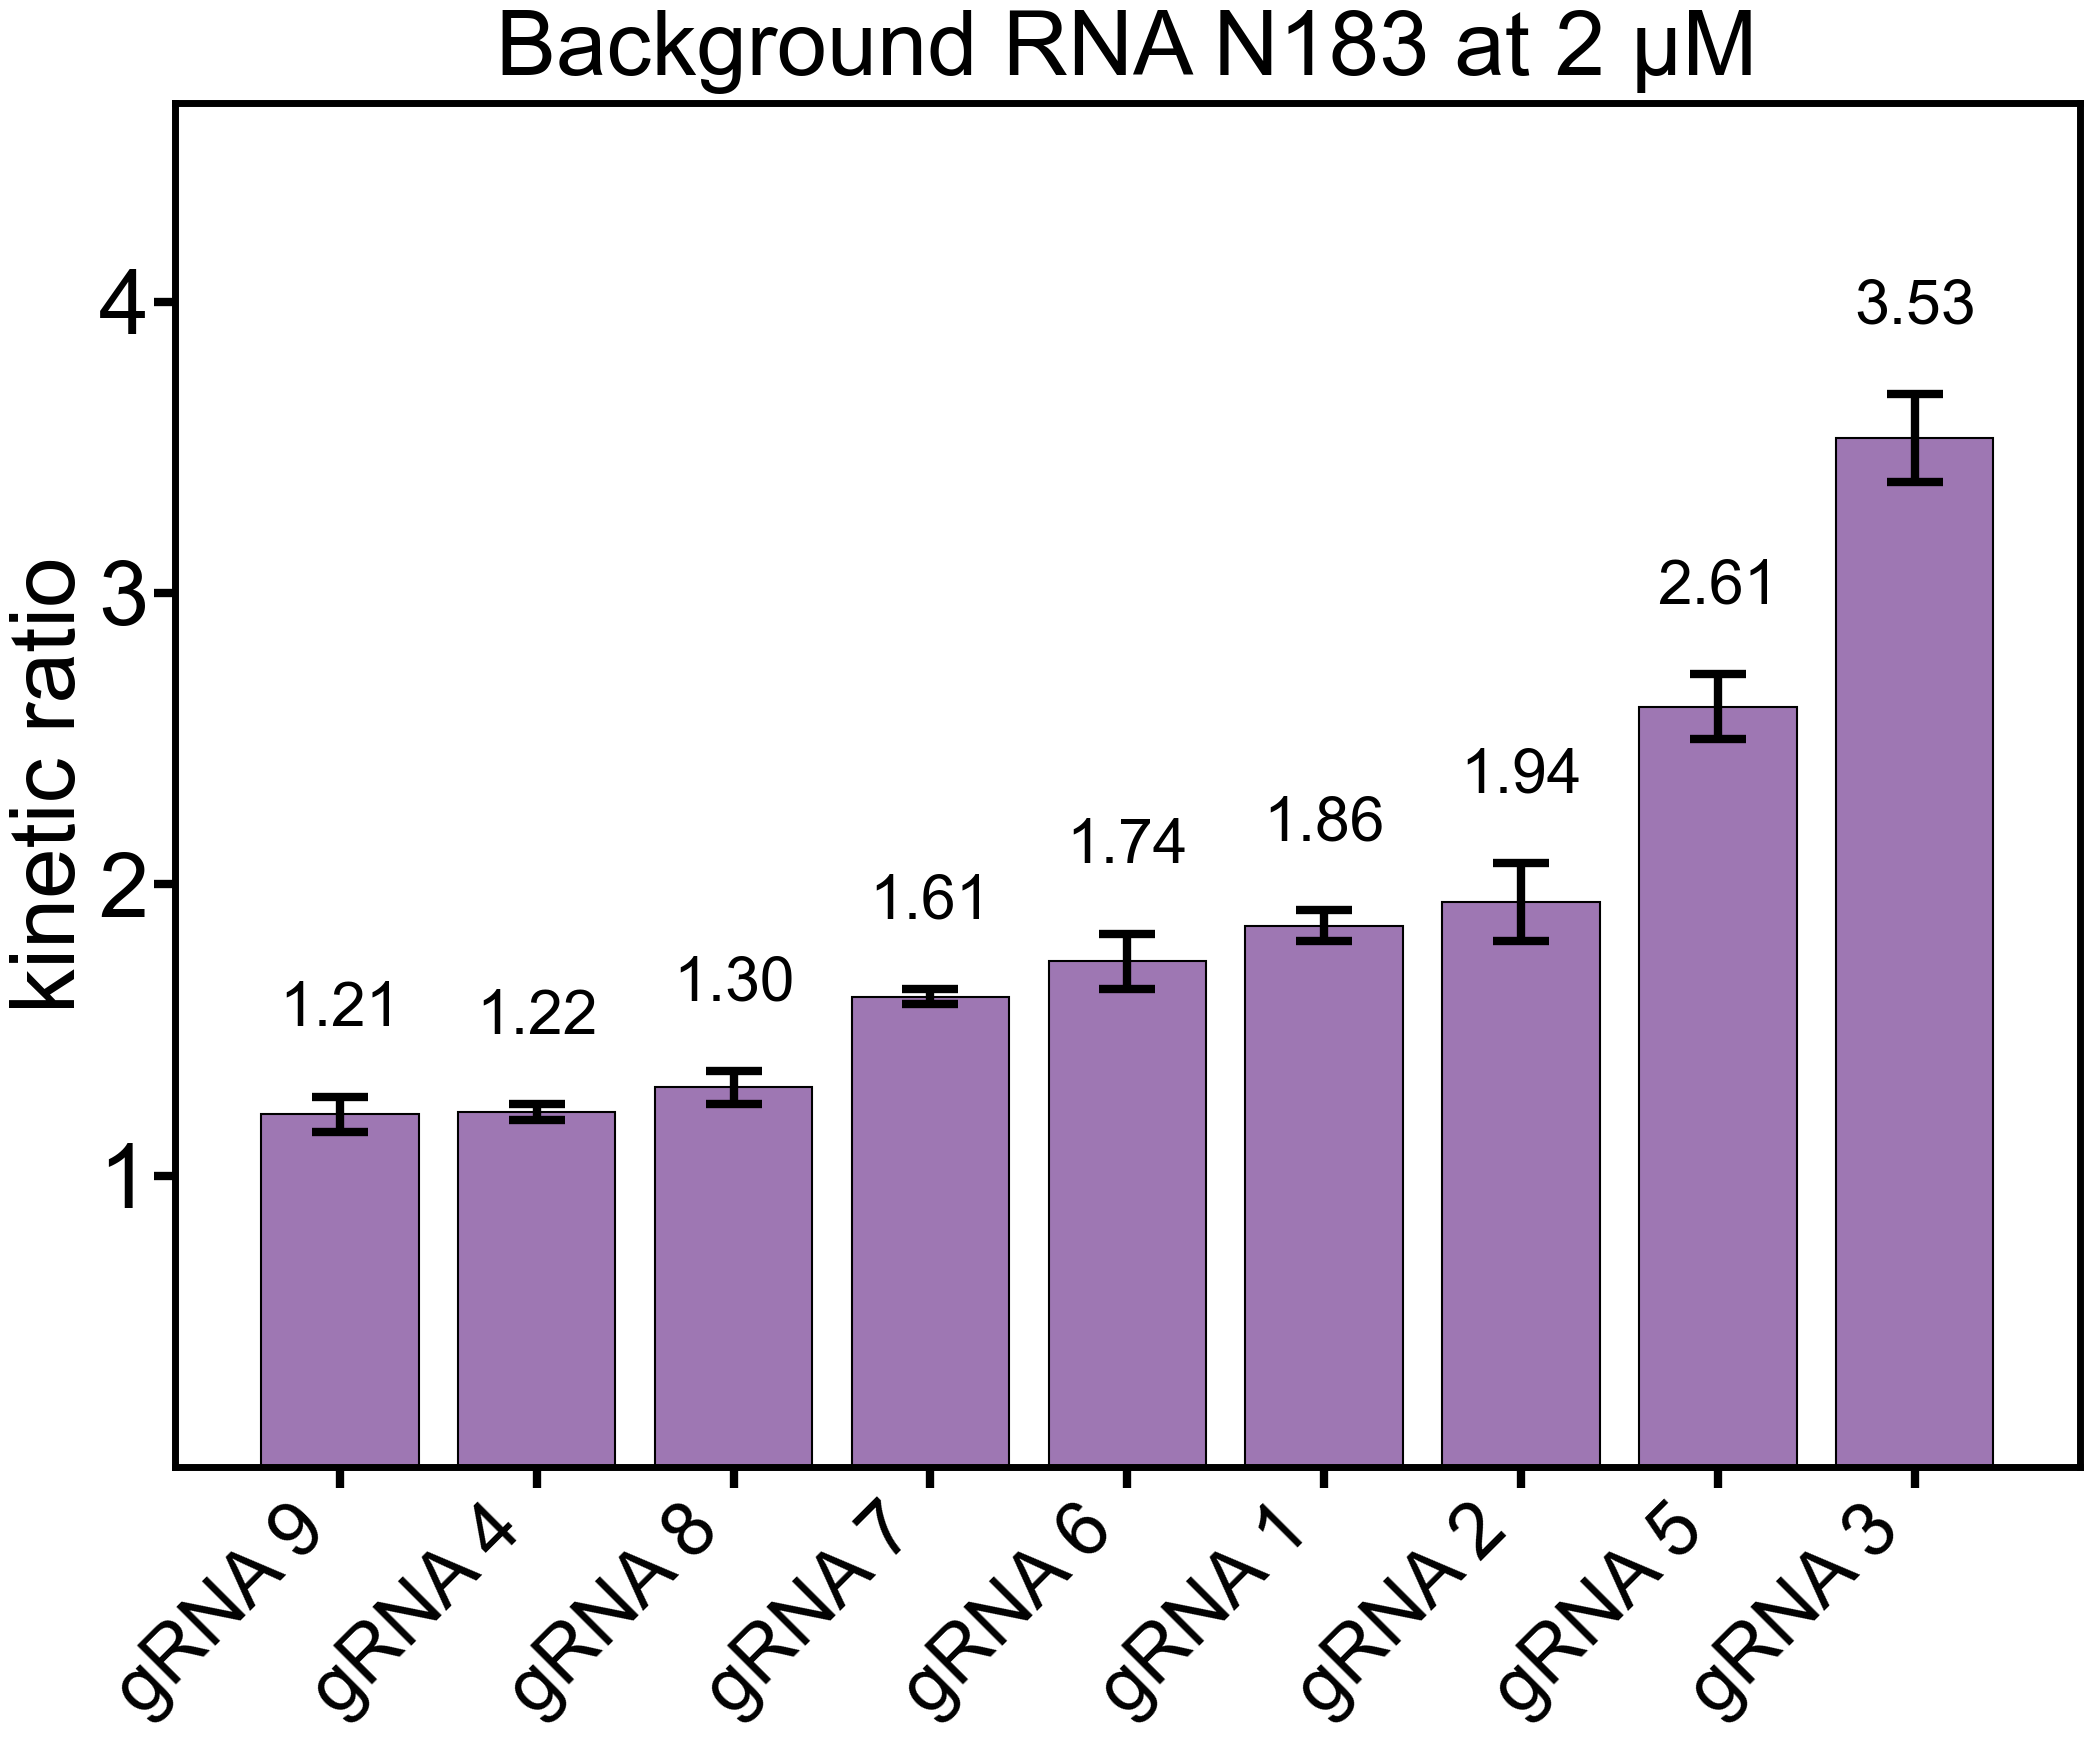

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

df = pd.read_excel("Figure3-RNA-Background.xlsx", sheet_name="Sheet1")

rna_cols      = [c for c in df.columns if " RNA" in c]
non_rna_cols  = [c for c in df.columns if c not in rna_cols + ["time"]]

def group_triplicates(cols):
    g = defaultdict(list)
    for c in cols:
        base = re.sub(r"\.1$|\.2$", "", c).strip()
        g[base].append(c)
    return g

rna_groups     = group_triplicates(rna_cols)
non_rna_groups = group_triplicates(non_rna_cols)

def get_t100(df, groups, threshold=100):
    out = {}
    for key, cols in groups.items():
        times = []
        for c in cols:
            df_above = df[df[c] > threshold]
            if not df_above.empty:
                times.append(df_above.iloc[0]["time"])
        if times:
            out[key] = times
    return out

t100_rna     = get_t100(df, rna_groups, 100)
t100_non_rna = get_t100(df, non_rna_groups, 100)

def normalize_label(label):
    return re.split(r"\s+RNA\b", label, 1)[0].strip()

normalized_non = { normalize_label(k): k for k in non_rna_groups }
match_map = {}
for r_key in rna_groups:
    short = normalize_label(r_key)
    if short in normalized_non:
        match_map[r_key] = normalized_non[short]

if not match_map:
    raise RuntimeError("No RNA→non‑RNA pairs found.  Check normalize_label logic.")

ratios = {}
for r_key, ref_key in match_map.items():
    a = t100_rna.get(r_key, [])
    b = t100_non_rna.get(ref_key, [])
    if a and b:
        cross = [x/y for x in a for y in b if y>0]
        if cross:
            ratios[r_key] = {
                "mean": np.mean(cross),
                "std": np.std(cross, ddof=1)
            }

items = sorted(
    [(normalize_label(k), v["mean"], v["std"]) for k,v in ratios.items()],
    key=lambda x: x[1]
)
if not items:
    raise RuntimeError("No valid ratios to plot—check your thresholds and pairings.")

x_labels, means, stds = zip(*items)

fig, ax = plt.subplots(figsize=(21, 17.5))
ax.bar(
    x_labels, means,
    yerr=stds,
    capsize=20,
    color='#9e77b3',
    edgecolor='black',
    linewidth=1.5,
    alpha=1,
    error_kw={"elinewidth":6, "capthick":6}
)
for bar, m, s in zip(ax.patches, means, stds):
    ax.text(
        bar.get_x()+bar.get_width()/2,
        m+s+0.2,
        f"{m:.2f}",
        ha='center', va='bottom',
        fontsize=45, fontweight='bold'
    )
ax.set_ylim(0, max(means)+max(stds)+1)
ax.set_yticks(np.arange(1, int(max(means)+max(stds))+2))
ax.set_ylabel("kinetic ratio", fontsize=65)
ax.tick_params(axis='both', which='major', length=15, width=6)
ax.tick_params(axis='y', labelsize=65)
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=55)
plt.title("Background RNA N183 at 2 µM", fontsize=65, weight='bold', pad=20)
plt.tight_layout()
plt.savefig("Figure3_RNA_Background.svg", format="svg", dpi=300)
plt.show()